<a href="https://colab.research.google.com/github/Oxford-EDI-Initiative/Face/blob/AC/InterFaceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Codebase and Models

In [12]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1 -O models/pretrain/pggan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 613 (delta 94), reused 91 (delta 91), pack-reused 489 (from 1)
Receiving objects: 100% (613/613), 13.72 MiB | 38.48 MiB/s, done.
Resolving deltas: 100% (204/204), done.


# Define Utility Functions

In [13]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [84]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

generator = build_generator(model_name)

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')

# Sample latent codes

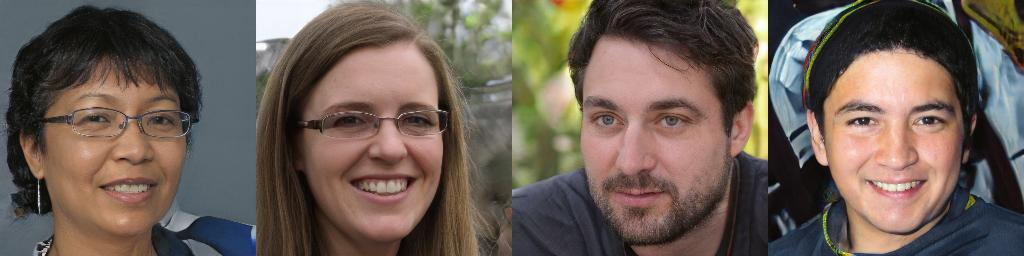

In [85]:
#@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 468 #@param {type:"slider", min:0, max:1000, step:1}

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

Updated latent code (gender-neutral = 0.0):



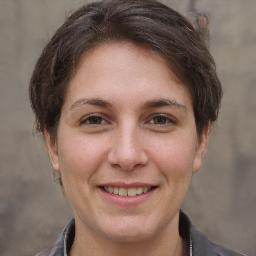

In [86]:
num_samples = 100  # Generate multiple faces for averaging
noise_seed = 388

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)

if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    synthesis_kwargs = {'latent_space_type': 'W'}
else:
    synthesis_kwargs = {}

# Neutralize gender & race
gender_value = 0.0  # 0 means gender-neutral
race_factors = {'asian': 0.0, 'indian': 0.0, 'black': 0.0, 'white': 0.0, 'middle eastern': 0.0, 'latino hispanic': 0.0}

neutral_code = latent_codes.mean(axis=0, keepdims=True)  # Average multiple samples
neutral_code += boundaries["gender"] * gender_value  # Keep gender-neutral

# Generate neutral image
neutral_image = generator.easy_synthesize(neutral_code, **synthesis_kwargs)["image"][0]

# Show final gender-neutral, race-neutral face
imshow(np.array([neutral_image]), col=1)


Modifying latent codes

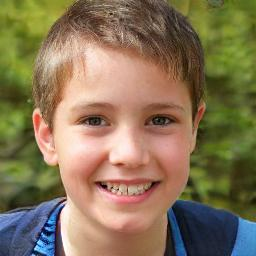

In [104]:
num_samples = 100  # Generate multiple faces to average or select the most neutral one
noise_seed = 106
latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)

neutral_face = None
min_gender_diff = float("inf")

for i in range(num_samples):
    modified_code = latent_codes[i:i+1]  # Copy of each latent vector

    # Apply a small modification for gender neutrality
    modified_code += boundaries["gender"] * 0.0  # You can also experiment with small ranges

    # Generate image
    image = generator.easy_synthesize(modified_code, **synthesis_kwargs)["image"][0]

    # Save image temporarily and analyze using DeepFace
    temp_path = f"/content/temp_face_{i}.jpg"
    cv2.imwrite(temp_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    # Analyze gender using DeepFace
    try:
        analysis = DeepFace.analyze(img_path=temp_path, actions=["gender"], enforce_detection=False)[0]
        male_prob = analysis["gender"]["Man"]
        female_prob = analysis["gender"]["Woman"]

        # Find the most gender-neutral face
        gender_diff = abs(male_prob - female_prob)
        if gender_diff < min_gender_diff:
            min_gender_diff = gender_diff
            neutral_face = image
    except:
        continue  # Skip if analysis fails

# Display the most gender-neutral face
imshow(np.array([neutral_face]), col=1)


# Edit facial attributes

updated code:

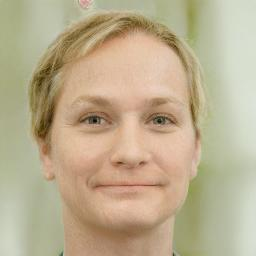

In [141]:
#@title { display-mode: "form", run: "auto" }

age = -0.2 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = -2.9 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = -0.95 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Copy neutral latent code
new_codes = modified_code.copy()

# Modify attributes
for attr_name in ATTRS:
    new_codes += boundaries[attr_name] * locals()[attr_name]  # Use locals() to get variable value

# Generate new image with adjusted attributes
new_image = generator.easy_synthesize(new_codes, **synthesis_kwargs)["image"][0]

# Display updated face
imshow(np.array([new_image]), col=1)


Sample code:

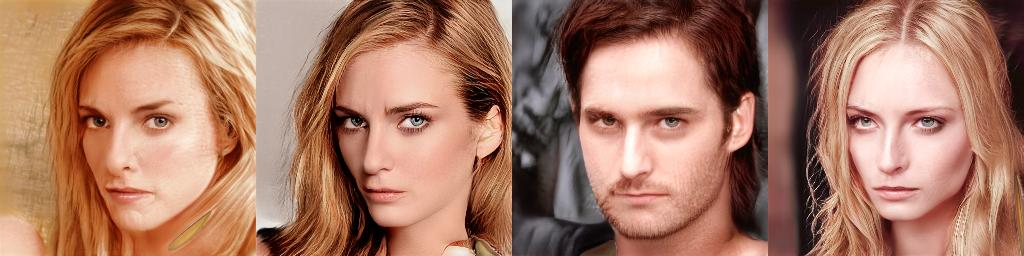

In [78]:
#@title { display-mode: "form", run: "auto" }

age = 0.1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = -2.9 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = 0.9 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = -1.5 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = -3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)

Testing resulting images

In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=be10fe08235774e9a486c88ee0a4df62e89e10391d6c351722b6f20828616f3c
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [ ]:
from deepface import DeepFace

25-03-07 20:49:30 - Directory /root/.deepface has been created
25-03-07 20:49:30 - Directory /root/.deepface/weights has been created


In [142]:
analysis = DeepFace.analyze(img_path = "/content/InterFaceGAN_5.png", actions = ["age", "gender", "emotion", "race"])

Action: race: 100%|██████████| 4/4 [00:00<00:00, 47.85it/s]


In [143]:
print(analysis)

[{'age': 28, 'region': {'x': 33, 'y': 45, 'w': 190, 'h': 190, 'left_eye': (158, 120), 'right_eye': (93, 119)}, 'face_confidence': 0.91, 'gender': {'Woman': 60.90903282165527, 'Man': 39.09096717834473}, 'dominant_gender': 'Woman', 'emotion': {'angry': 0.0017486320890369395, 'disgust': 1.250508677870436e-05, 'fear': 0.004155043163614126, 'happy': 46.3487980573653, 'sad': 0.23150331323613604, 'surprise': 0.016766124007321834, 'neutral': 53.39701493960708}, 'dominant_emotion': 'neutral', 'race': {'asian': 0.00013506213131352692, 'indian': 2.6658919861910337e-05, 'black': 2.8631245748842794e-07, 'white': 99.80336426516558, 'middle eastern': 0.06740827049513283, 'latino hispanic': 0.12907023379625285}, 'dominant_race': 'white'}]
